Bootstrap: locate repo root (Windows-safe) + env info

In [1]:
# [CELL 06-00] Bootstrap: locate repo root (Windows-safe) + env info

import sys, platform
from pathlib import Path
import torch
import numpy as np
import pandas as pd

print("CWD:", Path.cwd().resolve())
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("torch:", torch.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    for p in [start, *start.parents]:
        if (p / ".git").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd().resolve())
print("REPO_ROOT:", REPO_ROOT)

DATA_DIR = REPO_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
TENSOR_DIR = PROC_DIR / "tensor_target"
print("TENSOR_DIR:", TENSOR_DIR.resolve())


CWD: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\notebooks
Python: 3.11.14
Platform: Windows-10-10.0.22621-SP0
torch: 2.9.1+cpu
numpy: 2.4.0
pandas: 2.3.3
REPO_ROOT: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
TENSOR_DIR: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\data\processed\tensor_target


Config: RUN_TAG + load tensor packs + metadata (PyTorch 2.6+ safe)

In [2]:
# [CELL 06-01] Config: RUN_TAG + load tensor packs + metadata (PyTorch 2.6+ safe)

import json

RUN_TAG = "20251229_163357"

TRAIN_PT = TENSOR_DIR / f"target_tensor_train_{RUN_TAG}.pt"
VAL_PT   = TENSOR_DIR / f"target_tensor_val_{RUN_TAG}.pt"
TEST_PT  = TENSOR_DIR / f"target_tensor_test_{RUN_TAG}.pt"
META_JSON = TENSOR_DIR / f"target_tensor_metadata_{RUN_TAG}.json"
VOCAB_JSON = TENSOR_DIR / f"target_vocab_items_{RUN_TAG}.json"

for p in [TRAIN_PT, VAL_PT, TEST_PT, META_JSON, VOCAB_JSON]:
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p.resolve()}")

# PyTorch 2.6+ default weights_only=True breaks dict checkpoints; we must use weights_only=False
train_pack = torch.load(TRAIN_PT, map_location="cpu", weights_only=False)
val_pack   = torch.load(VAL_PT, map_location="cpu", weights_only=False)
test_pack  = torch.load(TEST_PT, map_location="cpu", weights_only=False)

with open(META_JSON, "r", encoding="utf-8") as f:
    meta = json.load(f)

with open(VOCAB_JSON, "r", encoding="utf-8") as f:
    vocab_blob = json.load(f)

vocab = vocab_blob["vocab"]
pad_id = int(meta["pad_id"])
unk_id = int(meta["unk_id"])
max_len = int(meta["max_len"])
vocab_size = int(meta["vocab_size"])

print("RUN_TAG:", RUN_TAG)
print("max_len:", max_len, "| vocab_size:", vocab_size, "| pad_id:", pad_id, "| unk_id:", unk_id)
print("train keys:", list(train_pack.keys()))
print("train input_ids:", tuple(train_pack["input_ids"].shape), "labels:", tuple(train_pack["labels"].shape))
print("val   input_ids:", tuple(val_pack["input_ids"].shape),   "labels:", tuple(val_pack["labels"].shape))
print("test  input_ids:", tuple(test_pack["input_ids"].shape),  "labels:", tuple(test_pack["labels"].shape))


RUN_TAG: 20251229_163357
max_len: 20 | vocab_size: 747 | pad_id: 0 | unk_id: 1
train keys: ['input_ids', 'attn_mask', 'labels', 'session_id', 'user_id', 't', 'split']
train input_ids: (1944, 20) labels: (1944,)
val   input_ids: (189, 20) labels: (189,)
test  input_ids: (200, 20) labels: (200,)


Define Dataset + DataLoader helpers (CHECKPOINT 1)

In [3]:
# [CELL 06-02] Define Dataset + DataLoader helpers (CHECKPOINT 1)

from torch.utils.data import Dataset, DataLoader

class NextItemTensorDataset(Dataset):
    """
    Wraps our saved dict packs:
      input_ids: [N, L]
      attn_mask: [N, L]
      labels:    [N]
    Also keeps debug ids: session_id, user_id, t, split
    """
    def __init__(self, pack: dict):
        self.pack = pack
        self.N = int(pack["input_ids"].shape[0])

    def __len__(self):
        return self.N

    def __getitem__(self, idx: int):
        out = {
            "input_ids": self.pack["input_ids"][idx],
            "attn_mask": self.pack["attn_mask"][idx],
            "labels": self.pack["labels"][idx],
            # debug fields (numpy arrays)
            "session_id": self.pack["session_id"][idx],
            "user_id": self.pack["user_id"][idx],
            "t": int(self.pack["t"][idx]),
            "split": self.pack["split"][idx],
        }
        return out

def make_loader(pack: dict, batch_size: int, shuffle: bool):
    ds = NextItemTensorDataset(pack)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

BATCH_SIZE = 256
train_loader = make_loader(train_pack, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = make_loader(val_pack,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(test_pack,  batch_size=BATCH_SIZE, shuffle=False)

# Quick batch sanity
b = next(iter(train_loader))
print("Batch keys:", list(b.keys()))
print("input_ids:", b["input_ids"].shape, "attn_mask:", b["attn_mask"].shape, "labels:", b["labels"].shape)
print("nonpad lens (first 5):", b["attn_mask"].sum(dim=1)[:5].tolist())
print("labels (first 5):", b["labels"][:5].tolist())

print("\nCHECKPOINT 1 ✅ Paste this cell output if anything looks off.")


Batch keys: ['input_ids', 'attn_mask', 'labels', 'session_id', 'user_id', 't', 'split']
input_ids: torch.Size([256, 20]) attn_mask: torch.Size([256, 20]) labels: torch.Size([256])
nonpad lens (first 5): [5, 1, 1, 16, 7]
labels (first 5): [10, 562, 534, 542, 121]

CHECKPOINT 1 ✅ Paste this cell output if anything looks off.


Metrics: HR@K, MRR@K, NDCG@K (vectorized)

In [4]:
# [CELL 06-03] Metrics: HR@K, MRR@K, NDCG@K (vectorized)

import torch

@torch.no_grad()
def metrics_at_k(scores: torch.Tensor, labels: torch.Tensor, k_list=(5, 10, 20)):
    """
    scores: [B, V] higher is better
    labels: [B] item ids in [0..V-1]
    returns dict like {"HR@10":..., "MRR@10":..., "NDCG@10":...}
    """
    assert scores.ndim == 2
    B, V = scores.shape
    assert labels.shape == (B,)

    # topk indices for max K
    max_k = max(k_list)
    topk = torch.topk(scores, k=max_k, dim=1).indices  # [B, max_k]
    lab = labels.view(-1, 1)                           # [B,1]
    hit_matrix = (topk == lab)                         # [B, max_k] bool

    out = {}
    for k in k_list:
        hits_k = hit_matrix[:, :k].any(dim=1).float()  # [B]
        hr = hits_k.mean().item()

        # rank position (1-based) if hit, else 0
        # find first True index
        pos = hit_matrix[:, :k].float().argmax(dim=1) + 1  # [B], but meaningless if no hit
        has_hit = hit_matrix[:, :k].any(dim=1)
        rr = torch.zeros(B, device=scores.device)
        rr[has_hit] = 1.0 / pos[has_hit].float()
        mrr = rr.mean().item()

        ndcg = torch.zeros(B, device=scores.device)
        ndcg[has_hit] = 1.0 / torch.log2(pos[has_hit].float() + 1.0)
        ndcg = ndcg.mean().item()

        out[f"HR@{k}"] = hr
        out[f"MRR@{k}"] = mrr
        out[f"NDCG@{k}"] = ndcg

    return out

print("Metrics function ready.")


Metrics function ready.


Evaluation runner (full-vocab) + padding safety

In [5]:
# [CELL 06-04] Evaluation runner (full-vocab) + padding safety

from collections import defaultdict

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

@torch.no_grad()
def eval_full_vocab(model_fn, loader, vocab_size: int, k_list=(5,10,20), desc="eval"):
    """
    model_fn(batch) -> scores [B, V] on DEVICE
    loader yields CPU tensors
    """
    agg = defaultdict(float)
    n_batches = 0
    n_rows = 0

    for batch in loader:
        # move tensors
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attn_mask"].to(DEVICE)
        labels    = batch["labels"].to(DEVICE)

        scores = model_fn(input_ids, attn_mask)  # [B,V]
        if scores.shape[1] != vocab_size:
            raise ValueError(f"{desc}: scores V={scores.shape[1]} != vocab_size={vocab_size}")

        # Optional: prevent recommending PAD
        scores[:, pad_id] = -1e9

        m = metrics_at_k(scores, labels, k_list=k_list)
        B = int(labels.shape[0])
        for key, val in m.items():
            agg[key] += val * B

        n_rows += B
        n_batches += 1

    for key in list(agg.keys()):
        agg[key] /= max(1, n_rows)

    return dict(agg), {"rows": n_rows, "batches": n_batches}


DEVICE: cpu


Protocol sanity check with two dummy baselines
(A) Random scores
(B) MostPop scores from TRAIN labels (very fast baseline)

In [6]:
# [CELL 06-05] Protocol sanity check with two dummy baselines:
#  (A) Random scores
#  (B) MostPop scores from TRAIN labels (very fast baseline)

import torch

K_LIST = (5, 10, 20)

# (A) Random scorer
def random_model_fn(input_ids, attn_mask):
    B = input_ids.shape[0]
    return torch.rand((B, vocab_size), device=input_ids.device)

m_rand, info_rand = eval_full_vocab(random_model_fn, val_loader, vocab_size, k_list=K_LIST, desc="random")
print("[SANITY] Random on VAL:", m_rand, "|", info_rand)

# (B) MostPop from TRAIN labels: score = item_count
train_labels = train_pack["labels"].numpy()
counts = np.bincount(train_labels, minlength=vocab_size).astype(np.float32)
pop_scores = torch.from_numpy(counts).to(DEVICE)  # [V]

def mostpop_model_fn(input_ids, attn_mask):
    B = input_ids.shape[0]
    return pop_scores.unsqueeze(0).repeat(B, 1)

m_pop, info_pop = eval_full_vocab(mostpop_model_fn, val_loader, vocab_size, k_list=K_LIST, desc="mostpop")
print("[SANITY] MostPop on VAL:", m_pop, "|", info_pop)

print("\nCHECKPOINT 2 ✅ Paste these two metric dicts (Random and MostPop).")


[SANITY] Random on VAL: {'HR@5': 0.010582010261714458, 'MRR@5': 0.00238095223903656, 'NDCG@5': 0.004325552377849817, 'HR@10': 0.021164020523428917, 'MRR@10': 0.0035714285913854837, 'NDCG@10': 0.007524122018367052, 'HR@20': 0.0317460335791111, 'MRR@20': 0.004147214349359274, 'NDCG@20': 0.009997575543820858} | {'rows': 189, 'batches': 1}
[SANITY] MostPop on VAL: {'HR@5': 0.08994708955287933, 'MRR@5': 0.053439151495695114, 'NDCG@5': 0.06234798580408096, 'HR@10': 0.13227513432502747, 'MRR@10': 0.05898211896419525, 'NDCG@10': 0.07594458758831024, 'HR@20': 0.1746031790971756, 'MRR@20': 0.061586860567331314, 'NDCG@20': 0.0862310603260994} | {'rows': 189, 'batches': 1}

CHECKPOINT 2 ✅ Paste these two metric dicts (Random and MostPop).


Plots (matplotlib): non-pad length distribution + label frequency head

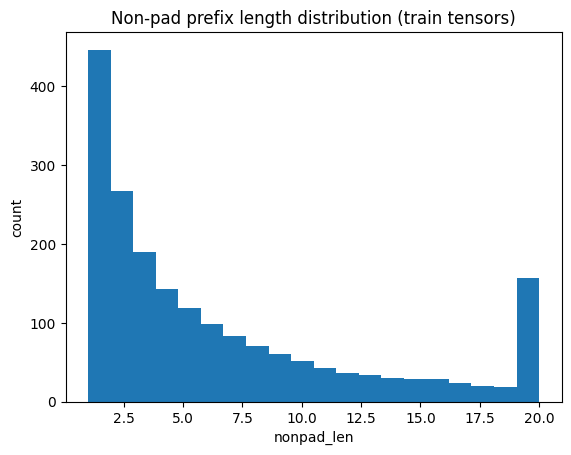

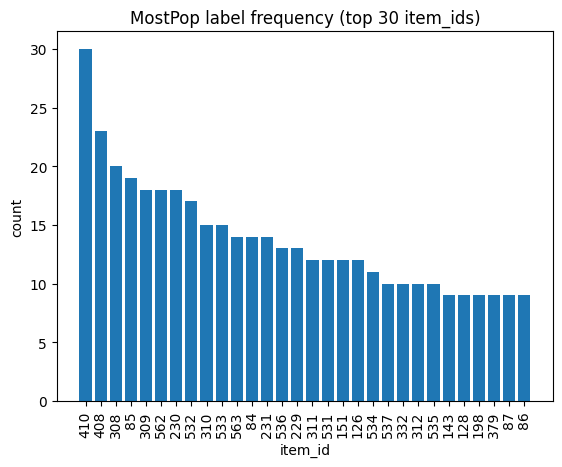

In [7]:
# [CELL 06-06] Plots (matplotlib): non-pad length distribution + label frequency head

import matplotlib.pyplot as plt

# non-pad lengths (train)
lens = train_pack["attn_mask"].sum(dim=1).numpy()

plt.figure()
plt.hist(lens, bins=20)
plt.title("Non-pad prefix length distribution (train tensors)")
plt.xlabel("nonpad_len")
plt.ylabel("count")
plt.show()

# label frequency (top 30)
topn = 30
top_idx = np.argsort(-counts)[:topn]
top_vals = counts[top_idx]

plt.figure()
plt.bar([str(i) for i in top_idx], top_vals)
plt.title("MostPop label frequency (top 30 item_ids)")
plt.xlabel("item_id")
plt.ylabel("count")
plt.xticks(rotation=90)
plt.show()


In [8]:
# [CELL META-00] Generate runs/<run_id>/meta.json (same schema as existing)

import json
import sys
import platform
from pathlib import Path
from datetime import datetime, timezone

import torch

# --- repo root (Windows-safe) ---
def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "PROJECT_STATE.md").exists():
            return p
    for p in [start, *start.parents]:
        if (p / ".git").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd().resolve())

# --- user-editable ---
NOTEBOOK_NAME = "06_data_loader_and_eval_protocol"  # <-- change per notebook
RUN_ID = None  # e.g. "exp_20251230_190000"; leave None to auto-generate

# --- auto run_id ---
if RUN_ID is None:
    RUN_ID = "exp_" + datetime.now().strftime("%Y%m%d_%H%M%S")

RUNS_DIR = REPO_ROOT / "runs"
EXP_DIR = RUNS_DIR / RUN_ID
EXP_DIR.mkdir(parents=True, exist_ok=True)

# --- build meta.json (match your existing structure) ---
created_utc = datetime.now(timezone.utc).isoformat()

meta = {
    "run_id": RUN_ID,
    "created_utc": created_utc,
    "python": sys.version.split()[0],
    "platform": f"{platform.system()} {platform.release()}",
    "torch": torch.__version__,
    "cuda_available": bool(torch.cuda.is_available()),
    "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
    "device_count": int(torch.cuda.device_count()) if torch.cuda.is_available() else 0,
    "extra": {
        "config": {
            "project": {"name": "mooc-coldstart-session-meta"},
            "paths": {
                "data_raw": "data/raw",
                "data_processed": "data/processed",
                "runs": "runs",
            },
            "repro": {"seed": 42, "deterministic": True},
            "training": {"num_workers": 2, "pin_memory": False},
        },
        "notebook": NOTEBOOK_NAME,
    },
}

OUT_META = EXP_DIR / "meta.json"
OUT_META.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

print("REPO_ROOT:", REPO_ROOT)
print("Wrote meta:", OUT_META.resolve())
print("run_id:", RUN_ID)
print("created_utc:", created_utc)


REPO_ROOT: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta
Wrote meta: D:\00_DS-ML-Workspace\mooc-coldstart-session-meta\runs\exp_20251230_220430\meta.json
run_id: exp_20251230_220430
created_utc: 2025-12-30T14:04:30.530004+00:00
